This notebook explores and displays how different preprocessing procedures interact with each other.
The aim is to remove eye-generated artifacts in FRPs.

We tested whether P1 SNR was affected by our preprocessing steps (calculated as the peak amplitude of the posterior channel with highest peak, over the GFP in the baseline of those same posterior channels). We wanted this measure to be maximal.

We also tried to find a pipeline that minimised vairability over channels. We had different GFP measures for that (baseline, around fixation onset, first 100 ms, last 300 ms).

Finally, we wanted to minimise saccadic-generated activity; for this we considered the amplitude and area under the curve and the rightmost frontal electrode.

All this analysis were performed on EEG (which seems relatively more affected than MEG sensors). May want to consider including MEG sensors in the calculations in the future (althuogh it seems pretty generalizable when looking at the reports).



We explored parameters in three different cases:

* **overweighting procedure**: we fitted the ICA with a dasaset that either  
    * was identical to the data ICA was applied to
    * oversampled saccades events for their entire duration (plus 20ms before and 10 after)
    * oversampled saccades events around their onset (-20 - +10 ms)
* **independent compononent selection**: we compared the
    * traditional approach of correlating components timecourse with EOG timecourse
    * ratio variance during fixation and saccadic events (variance of should be low during fixation and high during saccades if that component reflects saccadic artefacts
    * selecting componenst based on *both* EOG correlation and variance
* **high-pass filtering**
    * 0.1 Hz
    * 0.5 Hz
    * 1.0 Hz
    * 2.0 Hz

### Results

For filtering and indepedenet compononets selection methods we have some clear winners (0.5 high pass (especially helpful to remove drifts at later point in the epoch; selecting componenst based on *both* EOG correlation and ratio variance during fixation and saccadic events).

For the overweighting procedure there is come variabily across participants (which method works best).
Plus, the difference was relatively smaller compared to the other preprocessing steps.

We will adopt a by participant approach, selecting the method with the smallest areas when considering the snr measures.

In [53]:
import sys
import os
from os import path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

os.chdir("/home/fm02/MEG_NEOS/NEOS")
import NEOS_config as config

#os.chdir("/home/fm02/MEG_NEOS/NEOS/my_eyeCA")
from my_eyeCA import preprocess, ica, snr_metrics

os.chdir("/home/fm02/MEG_NEOS/NEOS")

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#mne.viz.set_browser_backend("matplotlib")

In [54]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib as mpl
#import shapely
# mpl.rcParams['figure.dpi'] = 150

In [55]:
ovr_metrics = dict()
ovrons_metrics = dict()
novr_metrics = dict()

do_subjs = [
            1,
            2,
            3,
        #   4, #fell asleep
            5,
            6,
        #    7, #no MRI
            8,
            9,
            10,
            11,
            12,
            13,
            14,
            15,
            16,
            17,
            18, 
            19, 
        #   20, #too magnetic to test
            21,
            22, 
            23,
            24,
            25,
            26,
            27,
            28,
            29,
            30
            ]

In [56]:
for sbj_id in do_subjs:
    
    sbj_metrics_ovr = pd.DataFrame()
    sbj_path = path.join(config.data_path, config.map_subjects[sbj_id][0])
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_ovrw_both.csv")
                                  )
        sbj_metrics_ovr = pd.concat([sbj_metrics_ovr, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovr = sbj_metrics_ovr.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovr = sbj_metrics_ovr.groupby(["type"]).mean()
    
    ovr_metrics[sbj_id] = sbj_metrics_ovr
    
    sbj_metrics_novr = pd.DataFrame()
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_both.csv")
                                  )
        sbj_metrics_novr = pd.concat([sbj_metrics_novr, blk_metrics], ignore_index=True)
    
    sbj_metrics_novr = sbj_metrics_novr.drop("Unnamed: 0", axis=1)
    sbj_metrics_novr = sbj_metrics_novr.groupby(["type"]).mean()
    novr_metrics[sbj_id] = sbj_metrics_novr
    
    sbj_metrics_ovrons = pd.DataFrame()
    
    for blk in range(1, 6):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_compare_filt_{sbj_id}_{blk}_ovrwonset_both.csv")
                                  )
        sbj_metrics_ovrons = pd.concat([sbj_metrics_ovrons, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovrons = sbj_metrics_ovrons.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovrons = sbj_metrics_ovrons.groupby(["type"]).mean()
    ovrons_metrics[sbj_id] = sbj_metrics_ovrons


df_ovr = pd.concat(ovr_metrics.values(), keys=ovr_metrics.keys())
df_ovrons = pd.concat(ovrons_metrics.values(), keys=ovrons_metrics.keys())
df_novr = pd.concat(novr_metrics.values(), keys=novr_metrics.keys())

norm_ovr = pd.DataFrame(columns=df_ovr.columns, index=df_ovr.index)
norm_ovrons = pd.DataFrame(columns=df_ovrons.columns, index=df_ovrons.index)
norm_novr = pd.DataFrame(columns=df_novr.columns, index=df_novr.index)

categories = [
              "P1_SNR",
              "GFP_first100",
              "GFP_baseline",
              "GFP_fixation_onset",
              "GFP_late",
              "S_amplitude",
              "S_auc",
             ]
for category in categories:
    scaler.fit(np.array(df_novr[category]).reshape(-1,1))
    norm_novr[category] = scaler.transform(np.array(df_novr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovr[category]).reshape(-1,1))
    norm_ovr[category] = scaler.transform(np.array(df_ovr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovrons[category]).reshape(-1,1))
    norm_ovrons[category] = scaler.transform(np.array(df_ovrons[category]).reshape(-1,1))

categories = [*categories, categories[0]]

In [57]:
def radar_plot(sbj_id, overweight, highpass_filter):   
    plt.close('all')
    
    OVR_01 = norm_ovr[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    OVR_05 = norm_ovr[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    OVR_10 = norm_ovr[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    OVR_20 = norm_ovr[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    OVR_01 = [*OVR_01, OVR_01[0]]
    OVR_05 = [*OVR_05, OVR_05[0]]
    OVR_10 = [*OVR_10, OVR_10[0]]
    OVR_20 = [*OVR_20, OVR_20[0]]
    
    nOVR_01 = norm_novr[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    nOVR_05 = norm_novr[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    nOVR_10 = norm_novr[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    nOVR_20 = norm_novr[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    nOVR_01 = [*nOVR_01, nOVR_01[0]]
    nOVR_05 = [*nOVR_05, nOVR_05[0]]
    nOVR_10 = [*nOVR_10, nOVR_10[0]]
    nOVR_20 = [*nOVR_20, nOVR_20[0]]
    
    OVRons_01 = norm_ovrons[categories].loc[sbj_id,"0.1Hz"].values[:-1]
    OVRons_05 = norm_ovrons[categories].loc[sbj_id,"0.5Hz"].values[:-1]
    OVRons_10 = norm_ovrons[categories].loc[sbj_id,"1.0Hz"].values[:-1]
    OVRons_20 = norm_ovrons[categories].loc[sbj_id,"2.0Hz"].values[:-1]

    OVRons_01 = [*OVRons_01, OVRons_01[0]]
    OVRons_05 = [*OVRons_05, OVRons_05[0]]
    OVRons_10 = [*OVRons_10, OVRons_10[0]]
    OVRons_20 = [*OVRons_20, OVRons_20[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    ovr={'All': False,
         'none': False,
         'no Overweighting': False, 
         'Overweighting': False, 
         'Onset Overweighting': False}
    
    filt={'All': False,
          'none': False,
          '0.1Hz': False,
          '0.5Hz': False,
          '1.0Hz': False}

    ovr[overweight]=True
    filt[highpass_filter]=True   
    
    fig = plt.figure(figsize=(8.5,9))
    ax = plt.subplot(111, polar=True)
    if ovr['All'] | filt['All']:
        ax.plot(label_loc, OVR_01, label='Overweighted - 0.1Hz')
        ax.plot(label_loc, OVR_05, label='Overweighted - 0.5Hz')
        ax.plot(label_loc, OVR_10, label='Overweighted - 1.0Hz')
        ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1Hz') 
        ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5Hz')
        ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0Hz')
        ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1Hz')
        ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5Hz')
        ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0Hz')
    else:        
        if (ovr['Overweighting']) | (filt['0.1Hz']): 
            ax.plot(label_loc, OVR_01, label='Overweighted - 0.1Hz')
        if (ovr['Overweighting']) | (filt['0.5Hz']): 
            ax.plot(label_loc, OVR_05, label='Overweighted - 0.5Hz')
        # ax.plot(label_loc, OVR_preICA, label='Overweighted - preICA')
        if (ovr['Overweighting']) | (filt['1.0Hz']): 
            ax.plot(label_loc, OVR_10, label='Overweighted - 1.0Hz')
        if (ovr['Onset Overweighting']) | (filt['0.1Hz']): 
            ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1Hz') 
        if (ovr['Onset Overweighting']) | (filt['0.5Hz']):
            ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5Hz')
        # ax.plot(label_loc, OVRons_preICA, label='Overweighted onset - preICA')
        if (ovr['Onset Overweighting']) | (filt['1.0Hz']):
            ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0Hz')
        if (ovr['no Overweighting']) | (filt['0.1Hz']):
            ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1Hz')
        if (ovr['no Overweighting']) | (filt['0.5Hz']):
            ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5Hz')
        if (ovr['no Overweighting']) | (filt['1.0Hz']):
            ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0Hz')


    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=3)
    fig.tight_layout()

    plt.show(fig)

In [58]:
widgets.interact(radar_plot, sbj_id=do_subjs,
                 overweight=['All','none','no Overweighting', 'Overweighting', 'Onset Overweighting'],
                 highpass_filter=['All','none', '0.1Hz', '0.5Hz', '1.0Hz']);

interactive(children=(Dropdown(description='sbj_id', options=(1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

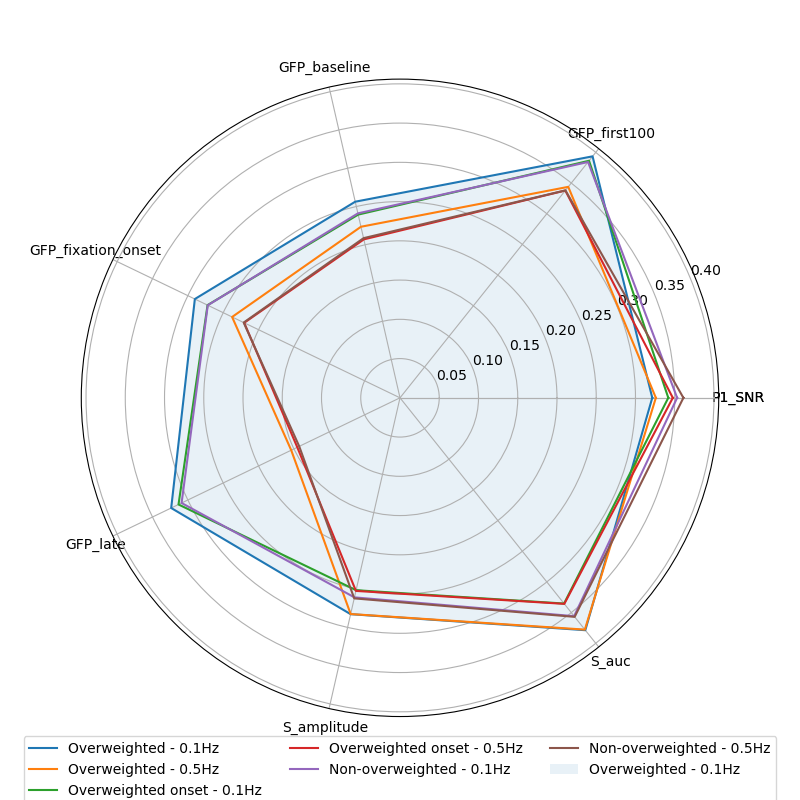

In [7]:
OVR_01Hz = norm_ovr[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
OVR_05Hz = norm_ovr[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
OVR_10Hz = norm_ovr[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0) 
OVR_20Hz = norm_ovr[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

OVRons_01Hz = norm_ovrons[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
OVRons_05Hz = norm_ovrons[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
OVRons_10Hz = norm_ovrons[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0) 
OVRons_20Hz = norm_ovrons[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

nOVR_01Hz = norm_novr[categories].loc[(slice(None), "0.1Hz"), :].mean(axis=0) 
nOVR_05Hz = norm_novr[categories].loc[(slice(None), "0.5Hz"), :].mean(axis=0) 
nOVR_10Hz = norm_novr[categories].loc[(slice(None), "1.0Hz"), :].mean(axis=0)
nOVR_20Hz = norm_novr[categories].loc[(slice(None), "2.0Hz"), :].mean(axis=0) 

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)    
ax.plot(label_loc, OVR_01Hz, label='Overweighted - 0.1Hz')
ax.plot(label_loc, OVR_05Hz, label='Overweighted - 0.5Hz')

ax.plot(label_loc, OVRons_01Hz, label='Overweighted onset - 0.1Hz')
ax.plot(label_loc, OVRons_05Hz, label='Overweighted onset - 0.5Hz')

ax.plot(label_loc, nOVR_01Hz, label='Non-overweighted - 0.1Hz')
ax.plot(label_loc, nOVR_05Hz, label='Non-overweighted - 0.5Hz')

ax.fill(label_loc, OVR_01Hz, label='Overweighted - 0.1Hz', alpha=0.1)
# plt.title('Average across participants', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
          ncol=3)
fig.tight_layout()

plt.show(fig)

In [8]:
df_ovr['Overweighting'] = 'OVER'
df_novr['Overweighting'] = 'NO_OVER'
df_ovrons['Overweighting'] = 'OVER_ONS'

all_ovr = pd.concat([df_ovr, df_novr, df_ovrons])

all_ovr.loc[:, all_ovr.columns!='Overweighting'].groupby(["type"]).agg(['mean', 'std'])


P1_SNR            P1_latency                GFP_n400                \
            mean        std       mean       std          mean           std   
type                                                                           
0.1Hz  18.859884  12.604187   0.103244  0.009165  9.960738e-07  4.519534e-07   
0.5Hz  19.140767  12.617203   0.102951  0.008962  6.847799e-07  2.450994e-07   
1.0Hz  19.402321  12.610674   0.103321  0.009238  5.559822e-07  1.888650e-07   
2.0Hz  18.706892  11.947808   0.103323  0.009097  4.873758e-07  1.909323e-07   

      S_amplitude           S_latency                   S_auc                \
             mean       std      mean       std          mean           std   
type                                                                          
0.1Hz    0.000004  0.000002  0.025914  0.008288  8.667755e-08  4.661813e-08   
0.5Hz    0.000004  0.000002  0.026010  0.008156  8.671892e-08  4.611620e-08   
1.0Hz    0.000004  0.000002  0.026020  0.008132  8.648912e-08  4.562432e-08   
2.0Hz    0.000004  0.000002  0.025960  0.008111  8.603562e-08  4.529604e-08   

       GFP_baseline                GFP_first100                \
               mean           std          mean           std   
type                                                            
0.1Hz  1.607829e-07  7.485753e-08  3.906041e-07  1.443773e-07   
0.5Hz  1.486167e-07  6.698068e-08  3.570270e-07  1.343487e-07   
1.0Hz  1.461806e-07  6.576610e-08  3.456676e-07  1.340972e-07   
2.0Hz  1.450245e-07  6.524801e-08  3.387330e-07  1.326773e-07   

      GFP_fixation_onset                    GFP_late                
                    mean           std          mean           std  
type                                                                
0.1Hz       2.981593e-07  1.336956e-07  5.563378e-07  3.189497e-07  
0.5Hz       2.669476e-07  1.133838e-07  2.937648e-07  1.763347e-07  
1.0Hz       2.551681e-07  1.021146e-07  1.609753e-07  1.076909e-07  
2.0Hz       2.567214e-07  9.883958e-08  1.171371e-07  7.893468e-08

In [9]:
all_ovr.groupby(["Overweighting"]).agg(['mean', 'std'])


P1_SNR            P1_latency                GFP_n400  \
                    mean        std       mean       std          mean   
Overweighting                                                            
NO_OVER        19.034639  12.452421   0.103300  0.009154  6.715479e-07   
OVER           19.247843  12.723309   0.103306  0.009053  6.915589e-07   
OVER_ONS       18.799915  12.107812   0.103024  0.009099  6.800520e-07   

                            S_amplitude           S_latency            \
                        std        mean       std      mean       std   
Overweighting                                                           
NO_OVER        3.467731e-07    0.000004  0.000002  0.025302  0.008629   
OVER           3.510086e-07    0.000004  0.000003  0.026957  0.007980   
OVER_ONS       3.510979e-07    0.000004  0.000002  0.025669  0.007750   

                      S_auc                GFP_baseline                \
                       mean           std          mean           std   
Overweighting                                                           
NO_OVER        8.387870e-08  4.181788e-08  1.504903e-07  6.907557e-08   
OVER           9.018312e-08  4.991432e-08  1.499476e-07  6.791375e-08   
OVER_ONS       8.537909e-08  4.520396e-08  1.500157e-07  6.852790e-08   

               GFP_first100               GFP_fixation_onset                \
                       mean           std               mean           std   
Overweighting                                                                
NO_OVER        3.579570e-07  1.390080e-07       2.701788e-07  1.138405e-07   
OVER           3.583401e-07  1.363356e-07       2.679722e-07  1.139946e-07   
OVER_ONS       3.577266e-07  1.377554e-07       2.695962e-07  1.141265e-07   

                   GFP_late                
                       mean           std  
Overweighting                              
NO_OVER        2.777232e-07  2.583911e-07  
OVER           2.871322e-07  2.589740e-07  
OVER_ONS       2.813059e-07  2.598049e-07

In [10]:
categories.append('Overweighting')

In [11]:
all_ovr[categories].groupby(['Overweighting', 'type']).agg(['mean','std'])


P1_SNR             GFP_first100                \
                          mean        std          mean           std   
Overweighting type                                                      
NO_OVER       0.1Hz  18.776285  12.968957  3.891374e-07  1.480844e-07   
              0.5Hz  19.137055  12.943121  3.568525e-07  1.372950e-07   
              1.0Hz  19.433905  12.670392  3.462935e-07  1.371039e-07   
              2.0Hz  18.791310  11.898686  3.395448e-07  1.358008e-07   
OVER          0.1Hz  19.136612  12.973024  3.917523e-07  1.442385e-07   
              0.5Hz  19.360561  12.936506  3.573272e-07  1.347988e-07   
              1.0Hz  19.623380  13.155471  3.456119e-07  1.345932e-07   
              2.0Hz  18.870821  12.536749  3.386690e-07  1.329399e-07   
OVER_ONS      0.1Hz  18.666754  12.336866  3.909227e-07  1.462888e-07   
              0.5Hz  18.924685  12.443911  3.569013e-07  1.360749e-07   
              1.0Hz  19.149677  12.473850  3.450974e-07  1.357049e-07   
              2.0Hz  18.458545  11.848330  3.379851e-07  1.343418e-07   

                     GFP_baseline               GFP_fixation_onset  \
                             mean           std               mean   
Overweighting type                                                   
NO_OVER       0.1Hz  1.611127e-07  7.641386e-08       2.985198e-07   
              0.5Hz  1.490367e-07  6.840622e-08       2.679537e-07   
              1.0Hz  1.464786e-07  6.720476e-08       2.563386e-07   
              2.0Hz  1.453333e-07  6.661548e-08       2.579031e-07   
OVER          0.1Hz  1.606461e-07  7.526149e-08       2.972837e-07   
              0.5Hz  1.483212e-07  6.722541e-08       2.655653e-07   
              1.0Hz  1.459939e-07  6.592532e-08       2.536957e-07   
              2.0Hz  1.448294e-07  6.547181e-08       2.553442e-07   
OVER_ONS      0.1Hz  1.605901e-07  7.575261e-08       2.986744e-07   
              0.5Hz  1.484922e-07  6.786300e-08       2.673237e-07   
              1.0Hz  1.460693e-07  6.667441e-08       2.554700e-07   
              2.0Hz  1.449110e-07  6.614423e-08       2.569169e-07   

                                       GFP_late               S_amplitude  \
                              std          mean           std        mean   
Overweighting type                                                          
NO_OVER       0.1Hz  1.359495e-07  5.479141e-07  3.271337e-07    0.000004   
              0.5Hz  1.146518e-07  2.876792e-07  1.787743e-07    0.000004   
              1.0Hz  1.029731e-07  1.584411e-07  1.087312e-07    0.000004   
              2.0Hz  9.954194e-08  1.168585e-07  8.003977e-08    0.000004   
OVER          0.1Hz  1.349606e-07  5.650635e-07  3.166200e-07    0.000004   
              0.5Hz  1.150390e-07  3.010816e-07  1.776349e-07    0.000004   
              1.0Hz  1.034792e-07  1.646396e-07  1.097381e-07    0.000004   
              2.0Hz  1.002331e-07  1.177440e-07  7.979749e-08    0.000004   
OVER_ONS      0.1Hz  1.352799e-07  5.560359e-07  3.249529e-07    0.000004   
              0.5Hz  1.147798e-07  2.925336e-07  1.790632e-07    0.000004   
              1.0Hz  1.037742e-07  1.598453e-07  1.086151e-07    0.000004   
              2.0Hz  1.005014e-07  1.168088e-07  7.997972e-08    0.000004   

                                      S_auc                   P1_SNR  \
                          std          mean           std       mean   
Overweighting type                                                     
NO_OVER       0.1Hz  0.000002  8.387511e-08  4.308864e-08  18.776285   
              0.5Hz  0.000002  8.407444e-08  4.256249e-08  19.137055   
              1.0Hz  0.000002  8.397691e-08  4.210891e-08  19.433905   
              2.0Hz  0.000002  8.358835e-08  4.189537e-08  18.791310   
OVER          0.1Hz  0.000003  9.066384e-08  5.138067e-08  19.136612   
              0.5Hz  0.000003  9.048963e-08  5.089241e-08  19.360561   
              1.0Hz  0.000003  9.006910e-08  5.034088e-08  19.623380   
 

In [12]:
ovr_metrics = dict()
ovrons_metrics = dict()
novr_metrics = dict()

for sbj_id in do_subjs:
    sbj_metrics_ovr = pd.DataFrame()
    sbj_path = path.join(config.data_path, config.map_subjects[sbj_id][0])
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_overweight.csv")
                                  )
        sbj_metrics_ovr = pd.concat([sbj_metrics_ovr, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovr = sbj_metrics_ovr.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovr = sbj_metrics_ovr.groupby(["type"]).mean()
    
    ovr_metrics[sbj_id] = sbj_metrics_ovr

    sbj_metrics_ovrons = pd.DataFrame()
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_overweight_onset.csv")
                                  )
        sbj_metrics_ovrons = pd.concat([sbj_metrics_ovrons, blk_metrics], ignore_index=True)
    
    sbj_metrics_ovrons = sbj_metrics_ovrons.drop("Unnamed: 0", axis=1)
    sbj_metrics_ovrons = sbj_metrics_ovrons.groupby(["type"]).mean()
    
    ovrons_metrics[sbj_id] = sbj_metrics_ovrons
    
    sbj_metrics_novr = pd.DataFrame()
    
    for i in range(5):
    
        blk_metrics = pd.read_csv(path.join(sbj_path,
                                            f"snr_componentselection_{sbj_id}_{i+1}_NOoverweight.csv")
                                  )
        sbj_metrics_novr = pd.concat([sbj_metrics_novr, blk_metrics], ignore_index=True)
    
    sbj_metrics_novr = sbj_metrics_novr.drop("Unnamed: 0", axis=1)
    sbj_metrics_novr = sbj_metrics_novr.groupby(["type"]).mean()
    novr_metrics[sbj_id] = sbj_metrics_novr

In [13]:
df_novr = pd.concat(novr_metrics.values(), keys=novr_metrics.keys())
df_ovr = pd.concat(ovr_metrics.values(), keys=ovr_metrics.keys())
df_ovrons = pd.concat(ovrons_metrics.values(), keys=ovrons_metrics.keys())

In [14]:
categories = [
              "P1_SNR",
              "GFP_first100",
              "GFP_baseline",
              "GFP_fixation_onset",
              "GFP_late",
              "S_amplitude",
              "S_auc",
             ]

# SNR does not need to be normalised as it has not unit, but other values 
# should be somehow scaled for comparison

norm_ovr = pd.DataFrame(columns=df_ovr.columns, index=df_ovr.index)
norm_ovrons = pd.DataFrame(columns=df_ovrons.columns, index=df_ovrons.index)
norm_novr = pd.DataFrame(columns=df_novr.columns, index=df_novr.index)

for category in norm_ovr.columns:
    scaler.fit(np.array(df_novr[category]).reshape(-1,1))
    norm_novr[category] = scaler.transform(np.array(df_novr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovr[category]).reshape(-1,1))
    norm_ovr[category] = scaler.transform(np.array(df_ovr[category]).reshape(-1,1))

    scaler.fit(np.array(df_ovrons[category]).reshape(-1,1))
    norm_ovrons[category] = scaler.transform(np.array(df_ovrons[category]).reshape(-1,1))

In [15]:
categories = [*categories, categories[0]]

In [16]:
def radar_plot(sbj_id, overweight, component_selection):
    plt.close('all')

    OVR_both = norm_ovr[categories].loc[sbj_id,"both"].values[:-1]
    OVR_eog = norm_ovr[categories].loc[sbj_id,"eog"].values[:-1]
    OVR_preICA = norm_ovr[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    OVR_var = norm_ovr[categories].loc[sbj_id,"variance"].values[:-1]
    
    OVRons_both = norm_ovrons[categories].loc[sbj_id,"both"].values[:-1]
    OVRons_eog = norm_ovrons[categories].loc[sbj_id,"eog"].values[:-1]
    OVRons_preICA = norm_ovrons[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    OVRons_var = norm_ovrons[categories].loc[sbj_id,"variance"].values[:-1]
       
    nOVR_both = norm_novr[categories].loc[sbj_id,"both"].values[:-1]
    nOVR_eog = norm_novr[categories].loc[sbj_id,"eog"].values[:-1]
#    nOVR_preICA = norm_novr[categories].loc[sbj_id,"pre-ICA"].values[:-1]
    nOVR_var = norm_novr[categories].loc[sbj_id,"variance"].values[:-1]
    
    
    OVR_both = [*OVR_both, OVR_both[0]]
    OVR_eog = [*OVR_eog, OVR_eog[0]]
    OVR_preICA = [*OVR_preICA, OVR_preICA[0]]
    OVR_var = [*OVR_var, OVR_var[0]]
 
    OVRons_both = [*OVRons_both, OVRons_both[0]]
    OVRons_eog = [*OVRons_eog, OVRons_eog[0]]
    OVRons_preICA = [*OVRons_preICA, OVRons_preICA[0]]
    OVRons_var = [*OVRons_var, OVRons_var[0]]
    
    nOVR_both = [*nOVR_both, nOVR_both[0]]
    nOVR_eog = [*nOVR_eog, nOVR_eog[0]]
#    nOVR_preICA = [*nOVR_preICA, nOVR_preICA[0]]
    nOVR_var = [*nOVR_var, nOVR_var[0]]
    
    ovr={'All': False,
         'no Overweighting': False, 
         'Overweighting': False, 
         'Onset Overweighting': False}
    
    comp={'All': False,
          'Both': False,
          'EOG': False,
          'Variance': False}

    ovr[overweight]=True
    comp[component_selection]=True
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    fig = plt.figure(figsize=(8.5,9))
    ax = plt.subplot(111, polar=True)
    if ovr['All'] | comp['All']:
        ax.plot(label_loc, OVR_both, label='Overweighted - Both')
        ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
        ax.plot(label_loc, OVR_var, label='Overweighted - Variance')
        ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both') 
        ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
        ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
        ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both')
        ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
        ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
    else:        
        if (ovr['Overweighting']) | (comp['Both']): 
            ax.plot(label_loc, OVR_both, label='Overweighted - Both', linewidth=3)
        if (ovr['Overweighting']) | (comp['EOG']): 
            ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
        # ax.plot(label_loc, OVR_preICA, label='Overweighted - preICA')
        if (ovr['Overweighting']) | (comp['Variance']): 
            ax.plot(label_loc, OVR_var, label='Overweighted - Variance')
        if (ovr['Onset Overweighting']) | (comp['Both']): 
            ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both', linewidth=3) 
        if (ovr['Onset Overweighting']) | (comp['EOG']):
            ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
        # ax.plot(label_loc, OVRons_preICA, label='Overweighted onset - preICA')
        if (ovr['Onset Overweighting']) | (comp['Variance']):
            ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
        if (ovr['no Overweighting']) | (comp['Both']):
            ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both', linewidth=3)
        if (ovr['no Overweighting']) | (comp['EOG']):
            ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
        if (ovr['no Overweighting']) | (comp['Variance']):
            ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
    #ax.fill(label_loc, OVR_both, label='Overweighted - Both', alpha=0.1)
    #plt.title(f'Participant {sbj_id}', size=20, y=1.05)
    
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.02),
              ncol=3)
    fig.tight_layout()
    plt.show(fig)
  

In [17]:
widgets.interact(radar_plot, sbj_id=do_subjs,
                 overweight=['All','none','no Overweighting', 'Overweighting', 'Onset Overweighting'],
                 component_selection=['All','none', 'Both', 'EOG', 'Variance']);

interactive(children=(Dropdown(description='sbj_id', options=(1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16,…

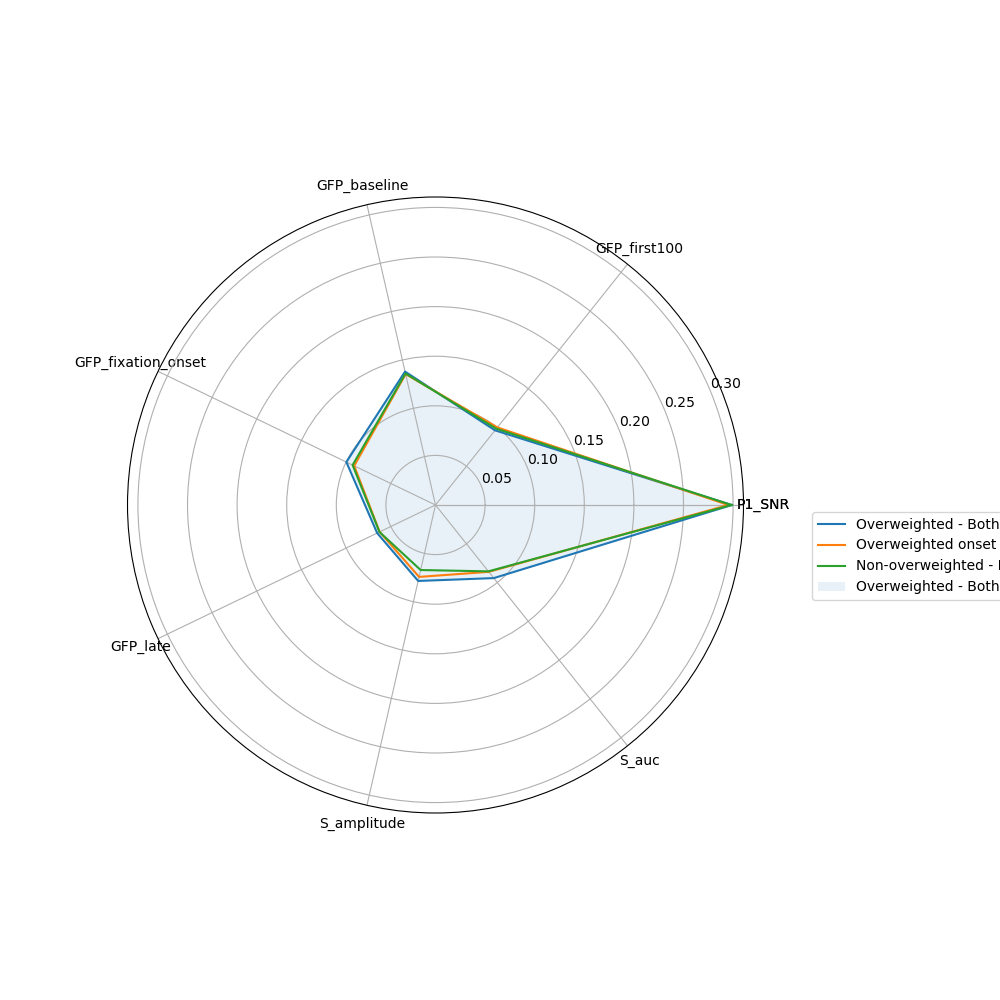

In [18]:
  

# average SNR

OVR_both = norm_ovr[categories].loc[(slice(None), "both"), :].mean(axis=0) 
OVR_eog = norm_ovr[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
OVR_preICA = norm_ovr[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0) 
OVR_var = norm_ovr[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

OVRons_both = norm_ovrons[categories].loc[(slice(None), "both"), :].mean(axis=0) 
OVRons_eog = norm_ovrons[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
OVRons_preICA = norm_ovrons[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0) 
OVRons_var = norm_ovrons[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

nOVR_both = norm_novr[categories].loc[(slice(None), "both"), :].mean(axis=0) 
nOVR_eog = norm_novr[categories].loc[(slice(None), "eog"), :].mean(axis=0) 
#    nOVR_preICA = norm_novr[categories].loc[(slice(None), "pre-ICA"), :].mean(axis=0)
nOVR_var = norm_novr[categories].loc[(slice(None), "variance"), :].mean(axis=0) 

label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111, polar=True)    
ax.plot(label_loc, OVR_both, label='Overweighted - Both')
#ax.plot(label_loc, OVR_eog, label='Overweighted - EOG')
#ax.plot(label_loc, OVR_preICA, label='preICA')
#ax.plot(label_loc, OVRons_var, label='Overweighted onset - Variance')
ax.plot(label_loc, OVRons_both, label='Overweighted onset - Both')
#ax.plot(label_loc, OVRons_eog, label='Overweighted onset - EOG')
#ax.plot(label_loc, OVRons_var, label='Overweighted - Variance')
ax.plot(label_loc, nOVR_both, label='Non-overweighted - Both')
#ax.plot(label_loc, nOVR_eog, label='Non-overweighted - EOG')
#    plt.plot(label_loc, nOVR_preICA, label='Non-overweighted - preICA')
#ax.plot(label_loc, nOVR_var, label='Non-overweighted - Variance')
ax.fill(label_loc, OVR_both, label='Overweighted - Both', alpha=0.1);
#plt.title('Average across participants', size=20, y=1.05)
lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
leg = ax.legend(loc='upper left', bbox_to_anchor=(1.1, 0.5), ncol=1)
leg = leg.set_in_layout(True)
plt.show()
    

In [19]:
df_ovr['Overweighting'] = 'OVER'
df_novr['Overweighting'] = 'NO_OVER'
df_ovrons['Overweighting'] = 'OVER_ONS'

all_ovr = pd.concat([df_ovr, df_novr, df_ovrons])

In [20]:
all_ovr.loc[:, all_ovr.columns!='Overweighting'].groupby(["type"]).agg(['mean', 'std'])

P1_SNR            P1_latency                GFP_n400  \
               mean        std       mean       std          mean   
type                                                                
both      18.852522  12.611534   0.103249  0.009172  9.958536e-07   
eog       18.691982  12.803442   0.103506  0.009217  1.043606e-06   
pre-ICA   20.029477  12.528696   0.103704  0.009213  3.644726e-06   
variance  19.424036  13.004449   0.103230  0.009079  1.369615e-06   

                       S_amplitude           S_latency            \
                   std        mean       std      mean       std   
type                                                               
both      4.521869e-07    0.000004  0.000002  0.025862  0.008220   
eog       4.888036e-07    0.000005  0.000003  0.025837  0.008281   
pre-ICA   1.560508e-06    0.000015  0.000006  0.032244  0.008981   
variance  8.163431e-07    0.000005  0.000003  0.027960  0.008610   

                 S_auc                GFP_baseline                \
                  mean           std          mean           std   
type                                                               
both      8.676121e-08  4.656816e-08  3.861600e-07  1.792318e-07   
eog       1.122771e-07  6.706111e-08  4.043935e-07  1.856219e-07   
pre-ICA   3.548065e-07  1.317061e-07  7.188556e-07  2.878976e-07   
variance  1.113815e-07  5.918280e-08  4.328463e-07  2.056712e-07   

          GFP_first100               GFP_fixation_onset                \
                  mean           std               mean           std   
type                                                                    
both      9.380814e-07  3.464942e-07       7.158854e-07  3.202817e-07   
eog       9.653216e-07  3.551745e-07       7.736182e-07  3.351423e-07   
pre-ICA   2.472422e-06  8.759362e-07       1.880656e-06  6.413561e-07   
variance  1.159357e-06  5.517667e-07       8.687182e-07  4.310612e-07   

          GFP_late                
              mean           std  
type                              
both      0.000001  7.640496e-07  
eog       0.000001  8.068692e-07  
pre-ICA   0.000005  2.440722e-06  
variance  0.000002  1.232298e-06

In [21]:
all_ovr.groupby(['Overweighting']).agg(['mean', 'std'])

P1_SNR            P1_latency            GFP_n400            \
                    mean        std       mean       std      mean       std   
Overweighting                                                                  
NO_OVER        19.161647  12.853509   0.103544  0.009098  0.000002  0.000001   
OVER           19.444463  12.789921   0.103363  0.009348  0.000002  0.000001   
OVER_ONS       19.142404  12.540587   0.103359  0.009023  0.000002  0.000001   

              S_amplitude           S_latency                   S_auc  \
                     mean       std      mean       std          mean   
Overweighting                                                           
NO_OVER          0.000007  0.000006  0.027322  0.009480  1.634487e-07   
OVER             0.000007  0.000006  0.029031  0.008526  1.714773e-07   
OVER_ONS         0.000007  0.000006  0.027574  0.008595  1.639938e-07   

                             GFP_baseline               GFP_first100  \
                        std          mean           std         mean   
Overweighting                                                          
NO_OVER        1.375232e-07  4.841040e-07  2.582787e-07     0.000001   
OVER           1.377212e-07  4.910111e-07  2.571351e-07     0.000001   
OVER_ONS       1.372343e-07  4.815765e-07  2.574358e-07     0.000001   

                            GFP_fixation_onset                GFP_late  \
                        std               mean           std      mean   
Overweighting                                                            
NO_OVER        8.557042e-07           0.000001  6.573467e-07  0.000002   
OVER           8.607156e-07           0.000001  6.583059e-07  0.000003   
OVER_ONS       8.534001e-07           0.000001  6.558940e-07  0.000002   

                         
                    std  
Overweighting            
NO_OVER        0.000002  
OVER           0.000002  
OVER_ONS       0.000002

In [22]:
categories.append('Overweighting')

In [23]:
all_ovr[categories].groupby(['Overweighting', 'type']).agg(['mean','std'])


P1_SNR             GFP_first100                \
                             mean        std          mean           std   
Overweighting type                                                         
NO_OVER       both      18.774944  12.969355  9.346702e-07  3.554240e-07   
              eog       18.708727  13.131595  9.582712e-07  3.629766e-07   
              pre-ICA   20.029477  12.688304  2.472422e-06  8.870950e-07   
              variance  19.133438  13.308887  1.110747e-06  5.134966e-07   
OVER          both      19.113957  12.995124  9.406742e-07  3.460612e-07   
              eog       18.838554  13.063284  9.762020e-07  3.592779e-07   
              pre-ICA   20.029477  12.688304  2.472422e-06  8.870950e-07   
              variance  19.795862  13.103786  1.298196e-06  6.358648e-07   
OVER_ONS      both      18.668665  12.336827  9.388997e-07  3.511489e-07   
              eog       18.528665  12.698652  9.614917e-07  3.565503e-07   
              pre-ICA   20.029477  12.688304  2.472422e-06  8.870950e-07   
              variance  19.342809  13.087481  1.069127e-06  4.876776e-07   

                        GFP_baseline               GFP_fixation_onset  \
                                mean           std               mean   
Overweighting type                                                      
NO_OVER       both      3.868246e-07  1.831022e-07       7.165959e-07   
              eog       4.041190e-07  1.887852e-07       7.699575e-07   
              pre-ICA   7.188556e-07  2.915652e-07       1.880656e-06   
              variance  4.266166e-07  2.078976e-07       8.391779e-07   
OVER          both      3.860876e-07  1.799171e-07       7.141546e-07   
              eog       4.054166e-07  1.891797e-07       7.777613e-07   
              pre-ICA   7.188556e-07  2.915652e-07       1.880656e-06   
              variance  4.536846e-07  2.110361e-07       9.530146e-07   
OVER_ONS      both      3.855678e-07  1.815097e-07       7.169055e-07   
              eog       4.036449e-07  1.859739e-07       7.731357e-07   
              pre-ICA   7.188556e-07  2.915652e-07       1.880656e-06   
              variance  4.182377e-07  2.041699e-07       8.139622e-07   

                                      GFP_late               S_amplitude  \
                                 std      mean           std        mean   
Overweighting type                                                         
NO_OVER       both      3.259598e-07  0.000001  7.834487e-07    0.000004   
              eog       3.378933e-07  0.000001  8.221963e-07    0.000005   
              pre-ICA   6.495266e-07  0.000005  2.471816e-06    0.000015   
              variance  4.200289e-07  0.000002  1.145022e-06    0.000005   
OVER          both      3.227591e-07  0.000001  7.586873e-07    0.000004   
              eog       3.492285e-07  0.000001  8.218960e-07    0.000005   
              pre-ICA   6.495266e-07  0.000005  2.471816e-06    0.000015   
              variance  4.681410e-07  0.000002  1.457722e-06    0.000005   
OVER_ONS      both      3.243518e-07  0.000001  7.784545e-07    0.000004   
              eog       3.308122e-07  0.000001  8.058200e-07    0.000005   
              pre-ICA   6.495266e-07  0.000005  2.471816e-06    0.000015   
              variance  4.059007e-07  0.000002  1.015626e-06    0.000005   

                                         S_auc                   P1_SNR  \
                             std          mean           std       mean   
Overweighting type                                                        
NO_OVER       both      0.000002  8.386589e-08  4.310264e-08  18.774944   
              eog       0.000003  1.086239e-07  6.315553e-08  18.708727   
              pre-ICA   0.000006  3.548065e-07  1.333840e-07  20.029477   
              variance  0.000003  1.064983e-07  5.569878e-08  19.133438   
OVER          both      0.000003  9.094217e-08  5.119745e-08  19.113957   
              eog       0.000004  1.175393e-07  7

In [24]:
df_ovr.loc[1]

P1_SNR  P1_latency      GFP_n400  S_amplitude  S_latency  \
type                                                                    
both      33.208371      0.0966  8.803342e-07     0.000003     0.0232   
eog       33.208371      0.0966  8.803342e-07     0.000003     0.0232   
pre-ICA   28.737104      0.0958  2.866744e-06     0.000019     0.0218   
variance  33.161757      0.0966  1.279962e-06     0.000004     0.0240   

                 S_auc  GFP_baseline  GFP_first100  GFP_fixation_onset  \
type                                                                     
both      7.593884e-08  3.897345e-07      0.000001        6.251478e-07   
eog       7.593884e-08  3.897345e-07      0.000001        6.251478e-07   
pre-ICA   4.745381e-07  5.876656e-07      0.000002        1.754081e-06   
variance  8.453265e-08  4.180326e-07      0.000001        8.111321e-07   

          GFP_late Overweighting  
type                              
both      0.000001          OVER  
eog       0.000001          OVER  
pre-ICA   0.000003          OVER  
variance  0.000002          OVER

This is not ideal because it does not take into account when there are big vs. small differences in some measures. In practice, it probably won't change much, but we might want to penalise those measure which do not capture well some of the aspects. 

In [59]:
get_thebest=dict()

for sbj_id in do_subjs:
    get_thebest[sbj_id] = []
    for category in categories:
        miniminum = np.argmin([df_ovr[category].loc[sbj_id]['0.5Hz'],
                         df_novr[category].loc[sbj_id]['0.5Hz'],
                         df_ovrons[category].loc[sbj_id]['0.5Hz']])
        print(f"""Subject {sbj_id} - Measure {category} - best is {['Over', 
                                                                  'NoOver', 
                                                                  'OverOns'][miniminum]}""")
        if category!='P1_SNR':
            get_thebest[sbj_id].append(miniminum)
    print("\n\n")

Subject 1 - Measure P1_SNR - best is OverOns
Subject 1 - Measure GFP_first100 - best is OverOns
Subject 1 - Measure GFP_baseline - best is OverOns
Subject 1 - Measure GFP_fixation_onset - best is Over
Subject 1 - Measure GFP_late - best is OverOns
Subject 1 - Measure S_amplitude - best is Over
Subject 1 - Measure S_auc - best is Over
Subject 1 - Measure P1_SNR - best is OverOns



Subject 2 - Measure P1_SNR - best is OverOns
Subject 2 - Measure GFP_first100 - best is Over
Subject 2 - Measure GFP_baseline - best is NoOver
Subject 2 - Measure GFP_fixation_onset - best is Over
Subject 2 - Measure GFP_late - best is NoOver
Subject 2 - Measure S_amplitude - best is Over
Subject 2 - Measure S_auc - best is Over
Subject 2 - Measure P1_SNR - best is OverOns



Subject 3 - Measure P1_SNR - best is Over
Subject 3 - Measure GFP_first100 - best is Over
Subject 3 - Measure GFP_baseline - best is Over
Subject 3 - Measure GFP_fixation_onset - best is Over
Subject 3 - Measure GFP_late - best is NoOver

In [60]:
    np.argmin([df_ovr['P1_SNR'].loc[1]['both'],
             df_novr['P1_SNR'].loc[1]['both'],
         df_ovrons['P1_SNR'].loc[1]['both']])

KeyError: 'both'

In [61]:
categories_tomin = categories.copy()

In [62]:
del(categories_tomin[0])
del(categories_tomin[-1])


In [63]:
categories_tomin
categories_tomin = [*categories_tomin, categories_tomin[0]]

In [64]:
categories_tomin

['GFP_first100',
 'GFP_baseline',
 'GFP_fixation_onset',
 'GFP_late',
 'S_amplitude',
 'S_auc',
 'GFP_first100']

In [65]:
loc_min = np.linspace(start=0, stop=2 * np.pi, num=len(categories_tomin))

In [66]:
loc_min[1]

1.0471975511965976

In [67]:
area_smallest = dict()

for sbj_id in do_subjs:
    area = dict()
    print(f"\n {sbj_id}")
    for i, test in zip(['novr','ovr','ovrons'],
                       [norm_novr, norm_ovr, norm_ovrons]):
        points = test[categories_tomin].loc[sbj_id].loc['0.5Hz'].values
        area[i] = 0
        for p in range(len(points)-1):
            area[i] += 0.5*(points[p]*points[p+1]*np.sin(loc_min[1]))

    print(i, area)
    area_smallest[sbj_id] = min(area, key=area.get)
    print(area_smallest[sbj_id])
        # this gives very similar outputs, although not exactly the same
#         x = np.cos(loc_min[1]) * test[categories_tomin].loc[sbj_id].loc['0.5Hz']
#         y = np.sin(loc_min[1]) * test[categories_tomin].loc[sbj_id].loc['0.5Hz']
# this gives the smallest convex set that contains a set of points
#         print(i, shapely.geometry.MultiPoint(list(zip(x, y))).convex_hull.area)
    


 1
ovrons {'novr': 0.33682481497715544, 'ovr': 0.1968681234039092, 'ovrons': 0.19653171165056404}
ovrons

 2
ovrons {'novr': 0.07574086595863244, 'ovr': 0.07298811473662335, 'ovrons': 0.08641196481964317}
ovr

 3
ovrons {'novr': 0.14473880209116707, 'ovr': 0.08440031017683619, 'ovrons': 0.2063827194819392}
ovr

 5
ovrons {'novr': 0.037086894666140395, 'ovr': 0.04038275148544028, 'ovrons': 0.0360859215967171}
ovrons

 6
ovrons {'novr': 0.02269332726712453, 'ovr': 0.022897058033443468, 'ovrons': 0.025229268309735618}
novr

 8
ovrons {'novr': 0.2295402980863816, 'ovr': 0.25483142738774234, 'ovrons': 0.24336867212238578}
novr

 9
ovrons {'novr': 0.13740354299906185, 'ovr': 0.08242427470647373, 'ovrons': 0.07908249709042176}
ovrons

 10
ovrons {'novr': 0.009764437214136692, 'ovr': 0.014598722254413648, 'ovrons': 0.012489378203002017}
novr

 11
ovrons {'novr': 0.6829551758941724, 'ovr': 0.6423337279589995, 'ovrons': 0.6225606053170555}
ovrons

 12
ovrons {'novr': 0.8892239356571485, 'ovr': 

In [68]:
categories_tomin

['GFP_first100',
 'GFP_baseline',
 'GFP_fixation_onset',
 'GFP_late',
 'S_amplitude',
 'S_auc',
 'GFP_first100']

This tells us the poligon with the smallest area for each participant.
We'll use this information to determine each participant overweighting procedure.

In [69]:
area_smallest

{1: 'ovrons',
 2: 'ovr',
 3: 'ovr',
 5: 'ovrons',
 6: 'novr',
 8: 'novr',
 9: 'ovrons',
 10: 'novr',
 11: 'ovrons',
 12: 'ovr',
 13: 'ovr',
 14: 'ovr',
 15: 'ovrons',
 16: 'novr',
 17: 'ovrons',
 18: 'novr',
 19: 'novr',
 21: 'ovrons',
 22: 'novr',
 23: 'ovrons',
 24: 'ovrons',
 25: 'ovrons',
 26: 'ovrons',
 27: 'ovrons',
 28: 'ovr',
 29: 'ovr',
 30: 'ovrons'}

In [70]:
pd.Series(area_smallest).value_counts()

ovrons    13
ovr        7
novr       7
dtype: int64

Plot the poligons from the above calculation for reference.
Note that the poligon does not contain P1_snr measure, so that any measure is to be minimised.

In [71]:
df_novr = norm_novr
df_ovr = norm_ovr
df_ovrons = norm_ovrons



In [72]:
categories_tomin = [*categories_tomin, categories_tomin[0]]

/tmp/ipykernel_31027/908963167.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6,6))


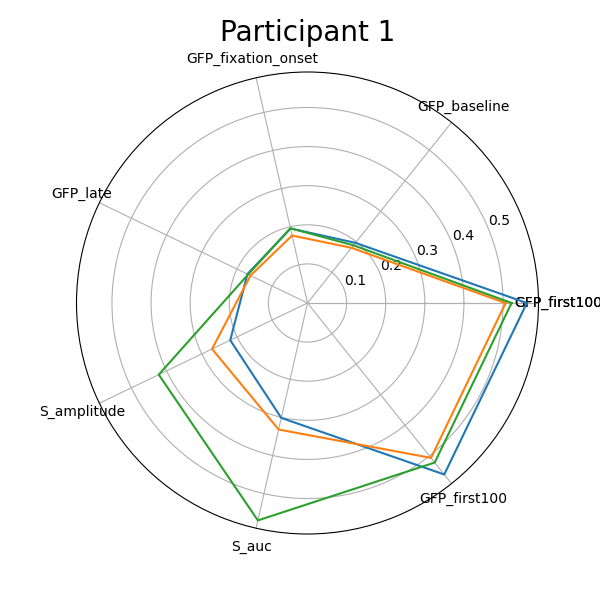

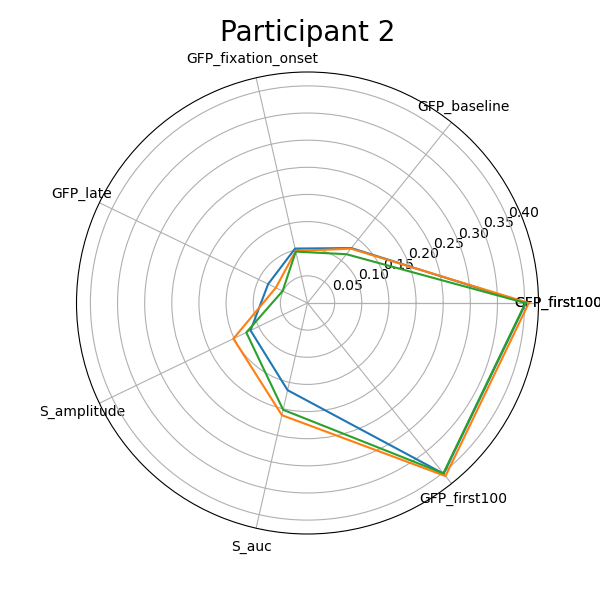

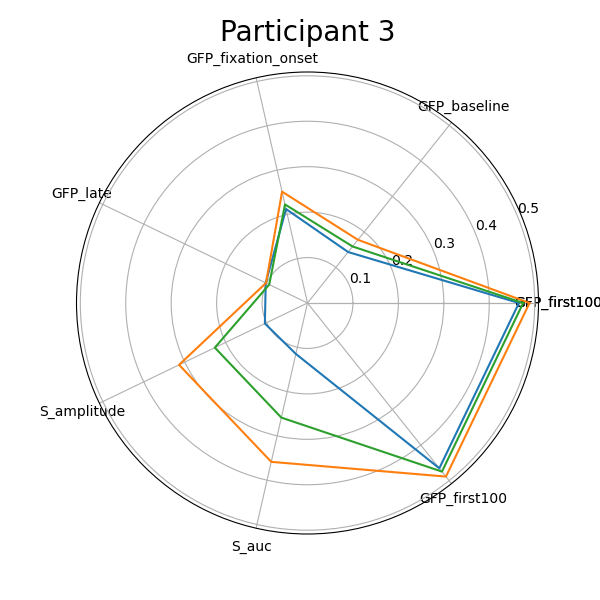

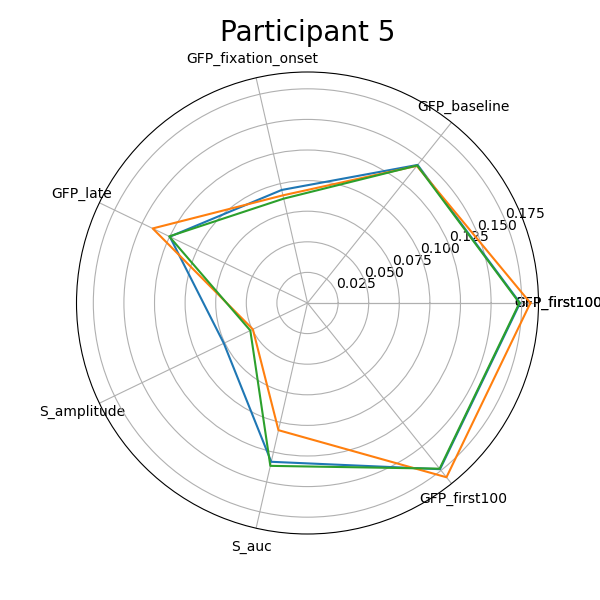

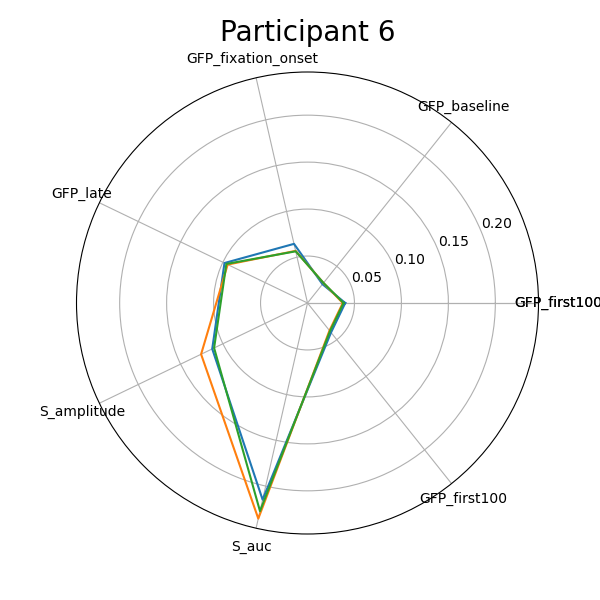

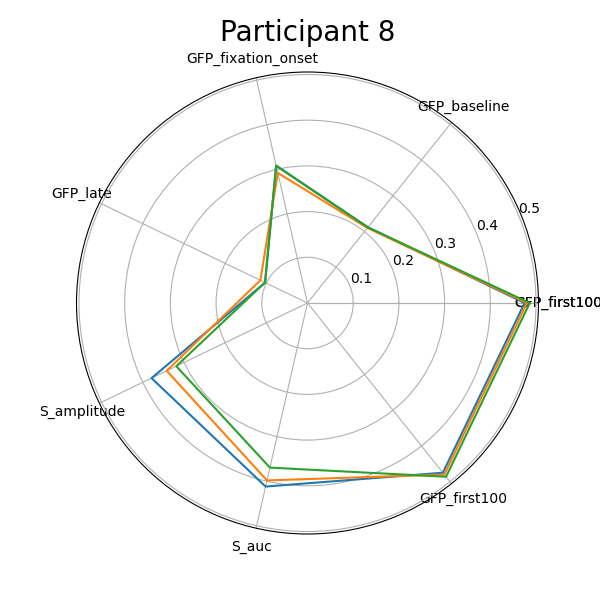

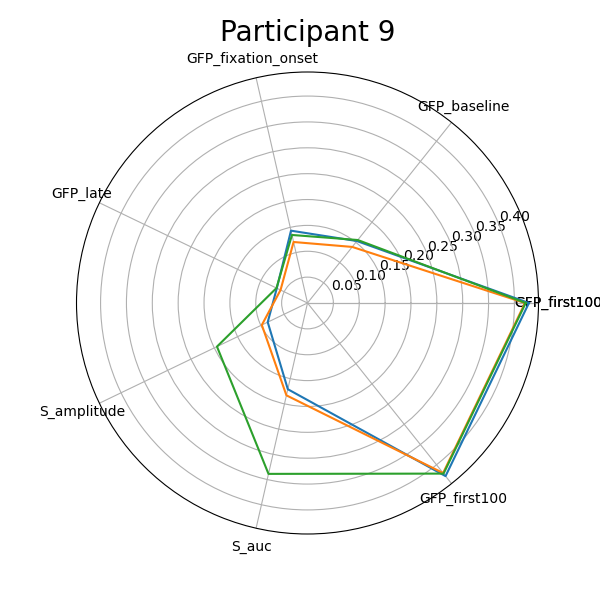

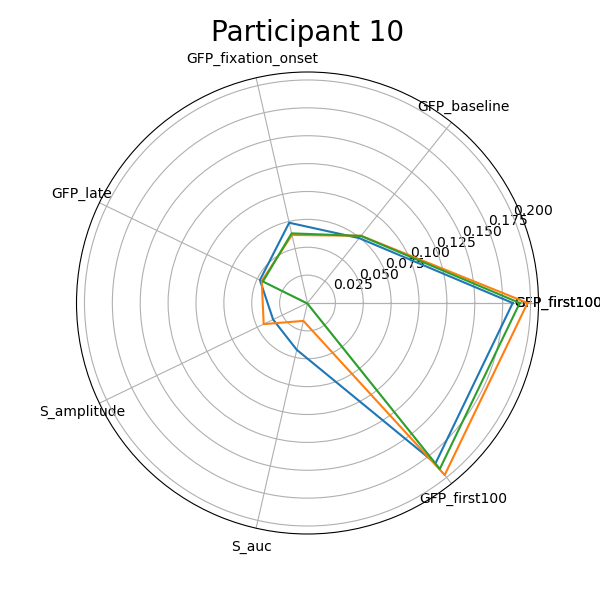

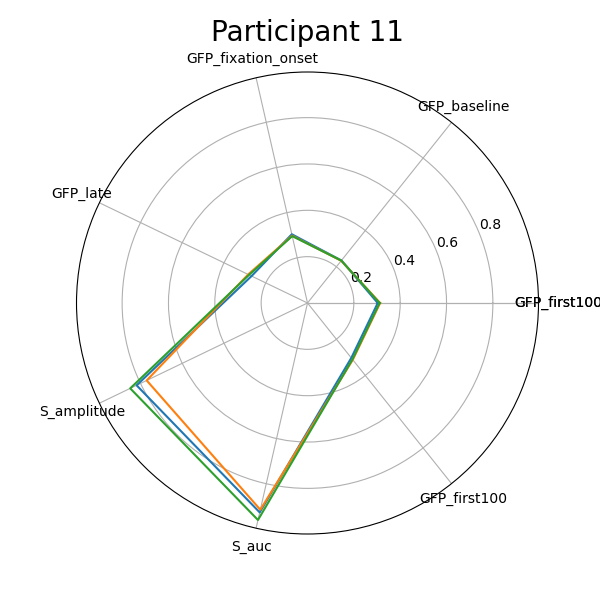

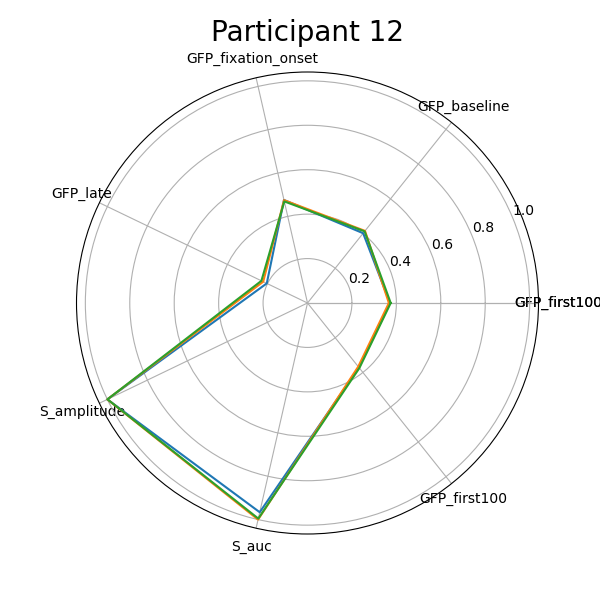

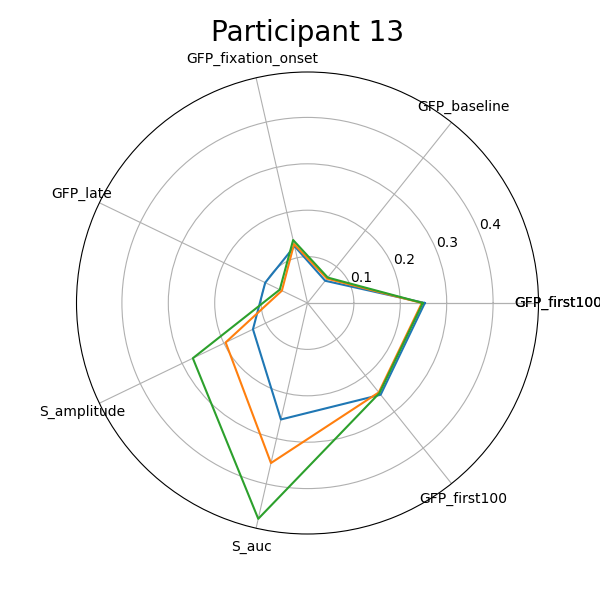

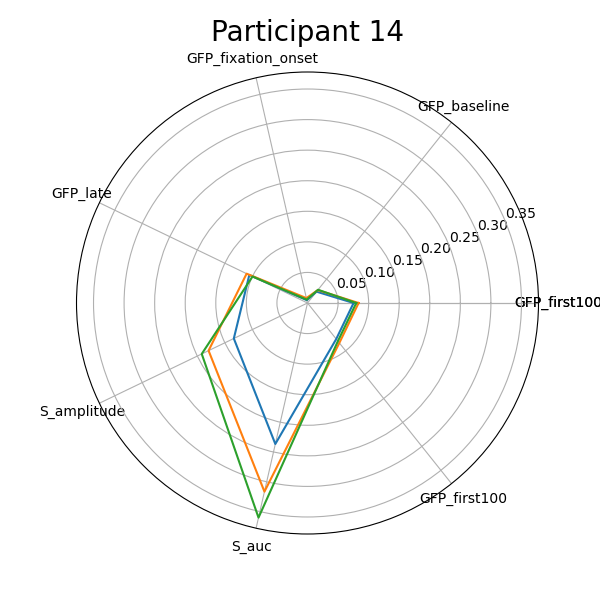

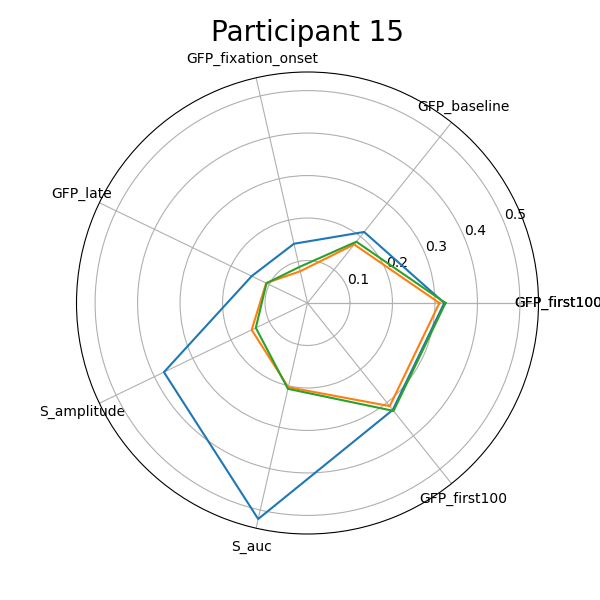

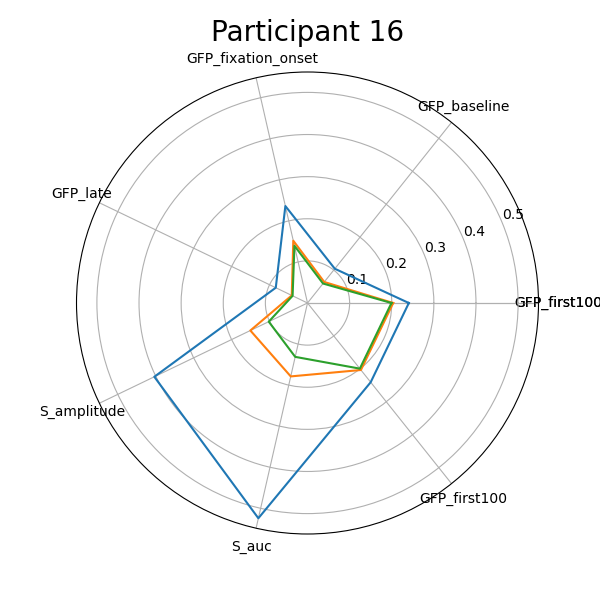

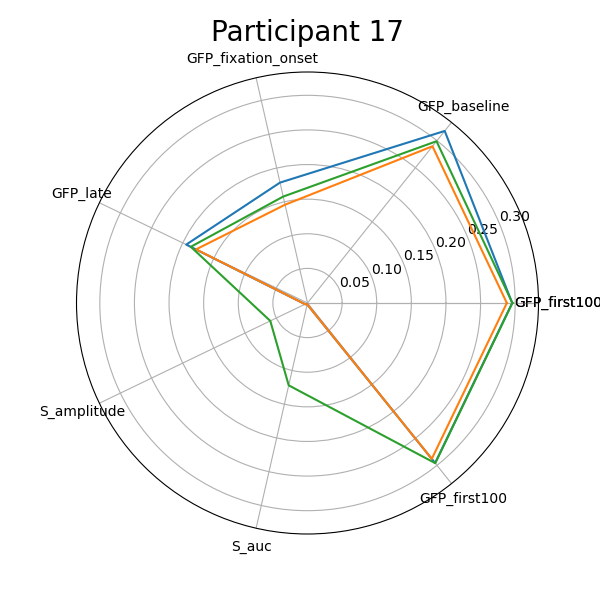

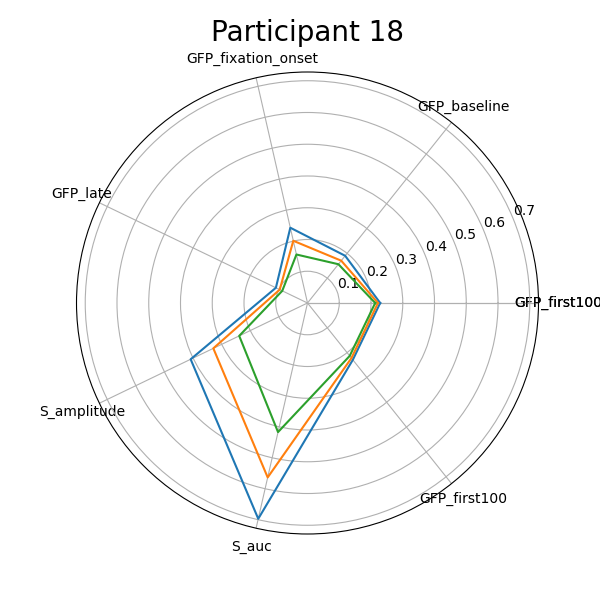

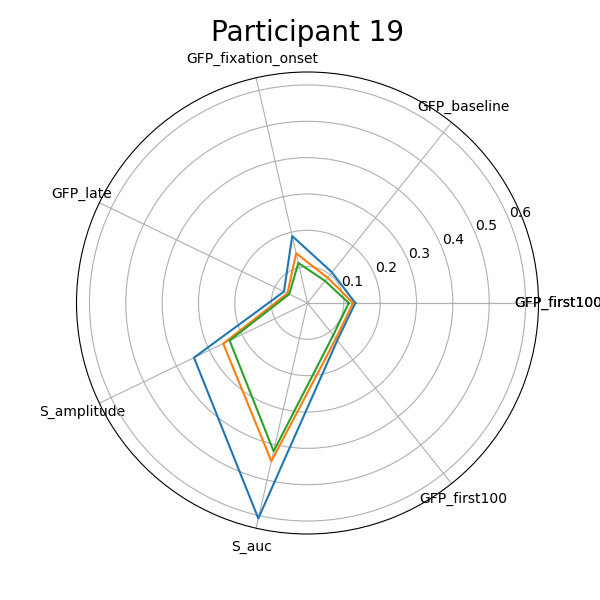

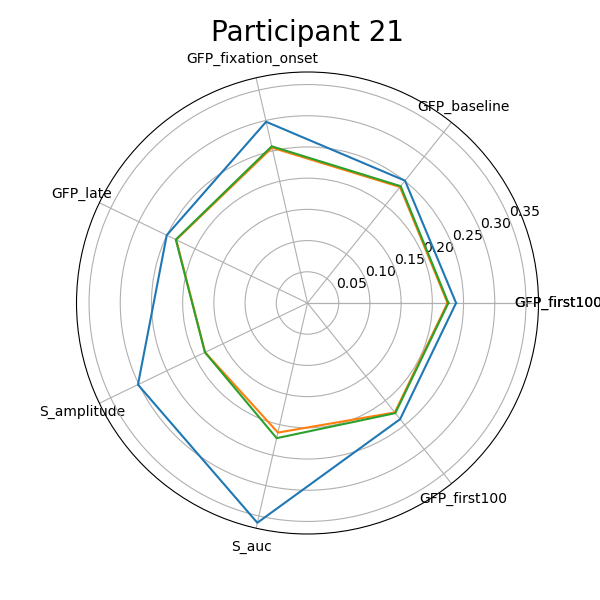

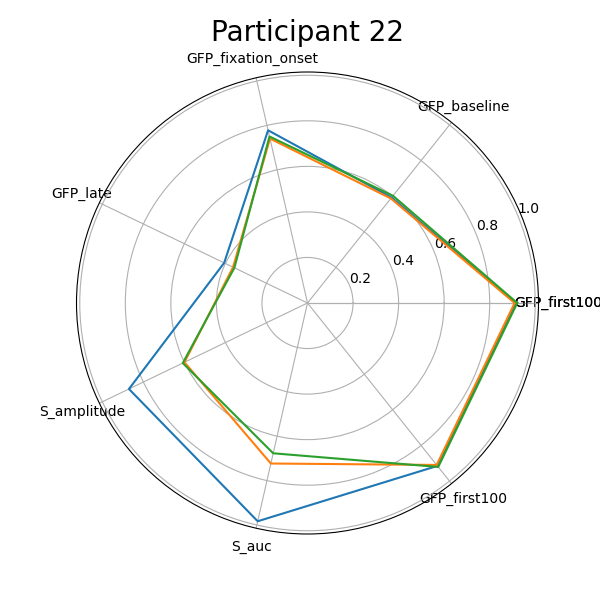

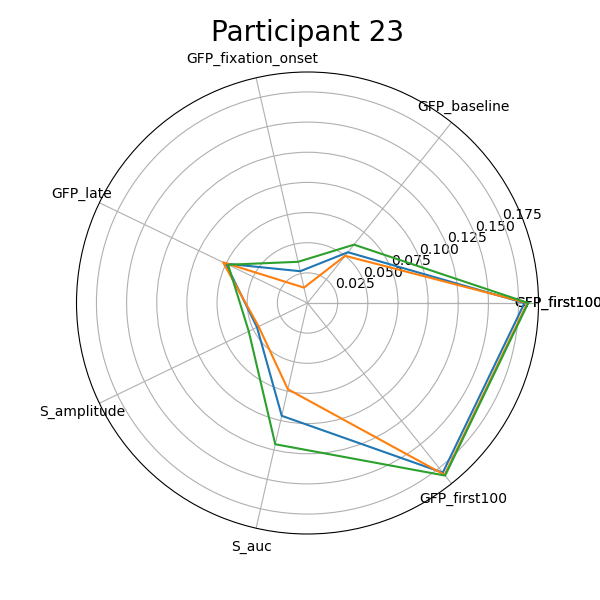

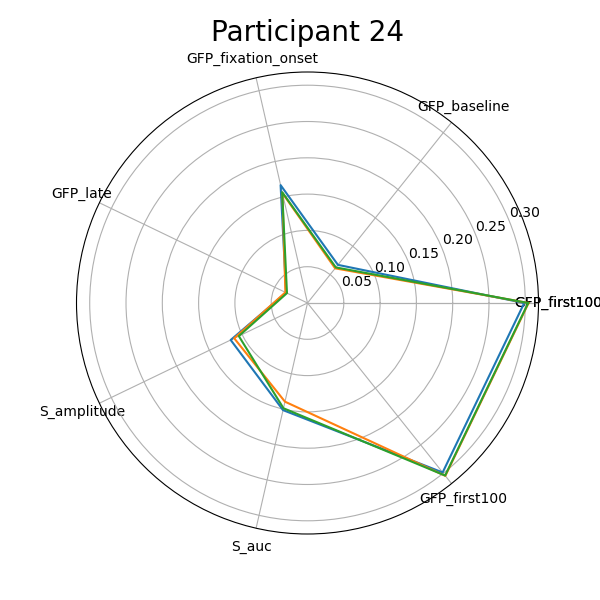

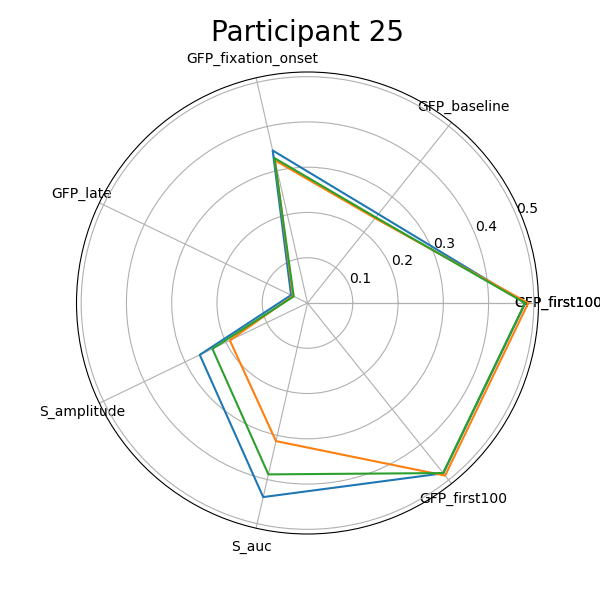

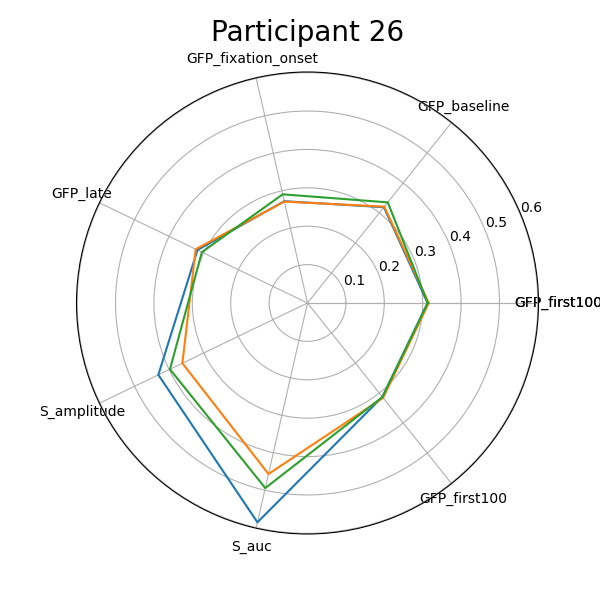

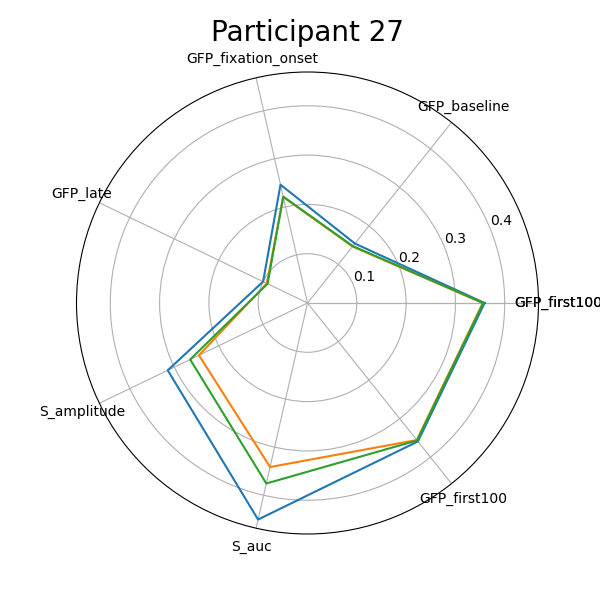

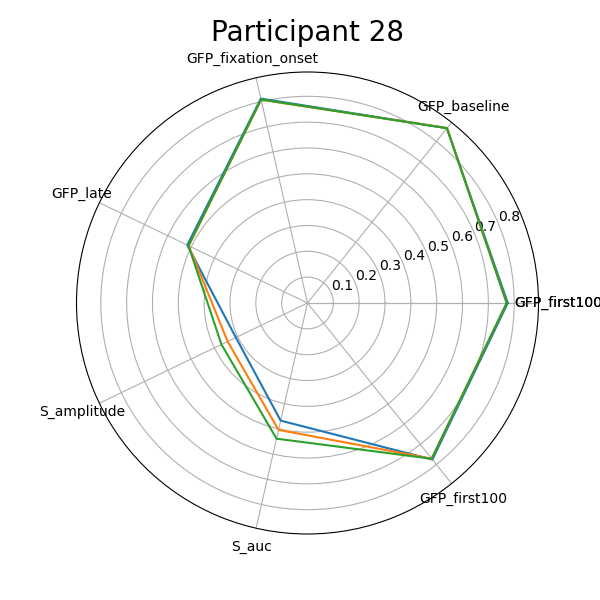

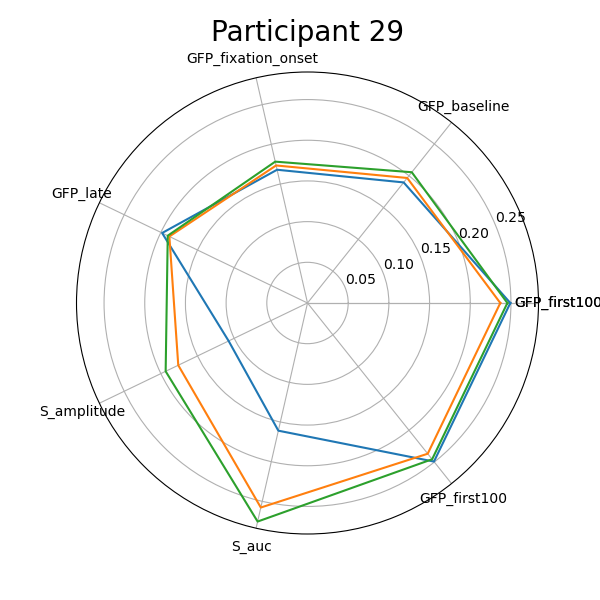

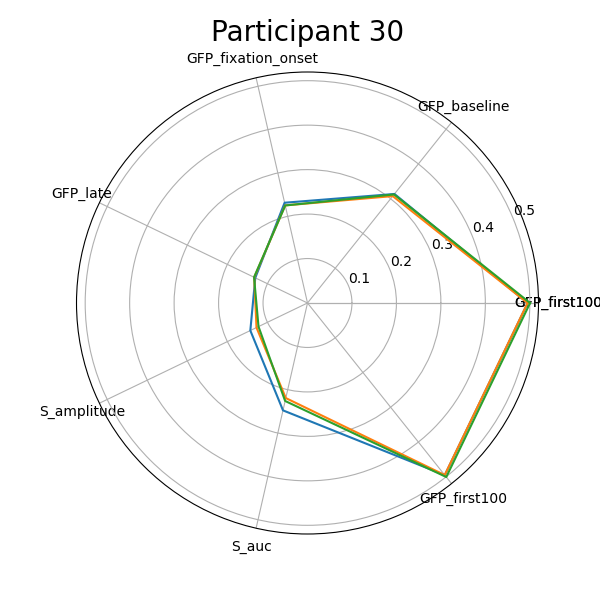

In [73]:
for sbj_id in do_subjs:
    OVR_01 = df_ovr[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    OVR_05 = df_ovr[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    OVR_10 = df_ovr[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    OVR_20 = df_ovr[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    OVR_01 = [*OVR_01, OVR_01[0]]
    OVR_05 = [*OVR_05, OVR_05[0]]
    OVR_10 = [*OVR_10, OVR_10[0]]
    OVR_20 = [*OVR_20, OVR_20[0]]
    
    nOVR_01 = df_novr[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    nOVR_05 = df_novr[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    nOVR_10 = df_novr[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    nOVR_20 = df_novr[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    nOVR_01 = [*nOVR_01, nOVR_01[0]]
    nOVR_05 = [*nOVR_05, nOVR_05[0]]
    nOVR_10 = [*nOVR_10, nOVR_10[0]]
    nOVR_20 = [*nOVR_20, nOVR_20[0]]
    
    OVRons_01 = df_ovrons[categories_tomin].loc[sbj_id,"0.1Hz"].values[:-1]
    OVRons_05 = df_ovrons[categories_tomin].loc[sbj_id,"0.5Hz"].values[:-1]
    OVRons_10 = df_ovrons[categories_tomin].loc[sbj_id,"1.0Hz"].values[:-1]
    OVRons_20 = df_ovrons[categories_tomin].loc[sbj_id,"2.0Hz"].values[:-1]

    OVRons_01 = [*OVRons_01, OVRons_01[0]]
    OVRons_05 = [*OVRons_05, OVRons_05[0]]
    OVRons_10 = [*OVRons_10, OVRons_10[0]]
    OVRons_20 = [*OVRons_20, OVRons_20[0]]

    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories_tomin))
    
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)    
    #ax.plot(label_loc, OVR_01, label='Overweighted - 0.1 Hz')
    ax.plot(label_loc, OVR_05, label='Overweighted - 0.5 Hz')
    # ax.plot(label_loc, OVR_10, label='Overweighted - 1.0 Hz')
    # ax.plot(label_loc, OVR_20, label='Overweighted - 2.0 Hz')
    
    #ax.plot(label_loc, OVRons_01, label='Overweighted onset - 0.1 Hz')
    ax.plot(label_loc, OVRons_05, label='Overweighted onset - 0.5 Hz')
    # ax.plot(label_loc, OVRons_10, label='Overweighted onset - 1.0 Hz')
    # ax.plot(label_loc, OVRons_20, label='Overweighted onset - 2.0 Hz')
    
    #ax.plot(label_loc, nOVR_01, label='Non-overweighted - 0.1 Hz')
    ax.plot(label_loc, nOVR_05, label='Non-overweighted - 0.5 Hz')
    # ax.plot(label_loc, nOVR_10, label='Non-overweighted - 1.0 Hz')
    # ax.plot(label_loc, nOVR_20, label='Non-overweighted - 2.0 Hz')
    
    #ax.fill(label_loc, OVR_01, label='Overweighted - 0.1 Hz', alpha=0.1)
    plt.title(f'Participant {sbj_id}', size=20, y=1.05)

    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories_tomin)